In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.auto import tqdm
import logging

G:\Anaconda\envs\YOLO\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
G:\Anaconda\envs\YOLO\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.2'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Logging and device configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
BATCH_SIZE = 8
NUM_EPOCHS = 10
LEARNING_RATE = 2e-4
DATA_DIR = r"G:\USER\Documents\GitHub\Masters-Project\Datasets\kvasir-dataset-v2"
SAVE_DIR = "medical_models"
MODEL_PATH = os.path.join(SAVE_DIR, 'best_model.pth')

# Ensure save directory exists
os.makedirs(SAVE_DIR, exist_ok=True)

In [3]:
class ROIDetector:
    def __init__(self, min_area=100, sigma=0.33):
        self.min_area = min_area
        self.sigma = sigma
    
    def auto_canny(self, image, sigma=None):
        if sigma is None:
            sigma = self.sigma
            
        # Compute the median of the single channel pixel intensities
        v = np.median(image)
        
        # Apply automatic Canny edge detection using the computed median
        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(min(255, (1.0 + sigma) * v))
        edged = cv2.Canny(image, lower, upper)
        
        return edged
    
    def detect_roi(self, image):
        # Convert to grayscale if not already
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
        
        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)
        
        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
        
        # Use auto Canny for edge detection
        edges = self.auto_canny(blurred)
        
        # Dilate to connect edges
        kernel = np.ones((3, 3), np.uint8)
        dilated = cv2.dilate(edges, kernel, iterations=1)
        
        # Find contours
        contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Filter contours by area and reject full image contours
        img_height, img_width = image.shape[:2]
        img_area = img_height * img_width
        
        valid_contours = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            x, y, w, h = cv2.boundingRect(cnt)
            
            # Skip if too small
            if area < self.min_area:
                continue
                
            # Skip if it's almost the entire image (>90% of image area)
            if w * h > 0.9 * img_area:
                continue
                
            valid_contours.append((x, y, w, h))
        
        # If no valid contours found, find areas with color variations
        if not valid_contours:
            # Convert to HSV color space
            if len(image.shape) == 3:
                hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                # Look for areas with significant saturation/value
                _, s, v = cv2.split(hsv)
                combined = cv2.addWeighted(s, 0.5, v, 0.5, 0)
                # Threshold
                _, thresh = cv2.threshold(combined, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                # Find contours on this new threshold
                contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
                for cnt in contours:
                    area = cv2.contourArea(cnt)
                    if area >= self.min_area:
                        valid_contours.append(cv2.boundingRect(cnt))
        
        return valid_contours
    
    def crop_to_roi(self, image, roi):
        x, y, w, h = roi
        return image[y:y+h, x:x+w]

In [4]:
class KvasirDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.roi_detector = ROIDetector()
        
        # Augmentation techniques
        self.augmentation = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussNoise(p=0.2),
            A.Blur(blur_limit=3, p=0.2),
        ])
        
        self.processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
        
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        # Read image
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Could not read image: {img_path}")
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Detect ROIs
        rois = self.roi_detector.detect_roi(img)
        
        # If ROIs found, crop to the largest region
        if rois:
            largest_roi = max(rois, key=lambda r: r[2] * r[3])
            img = self.roi_detector.crop_to_roi(img, largest_roi)
        
        # Apply augmentation
        if self.transform:
            augmented = self.augmentation(image=img)
            img = augmented['image']
        
        # Explicitly resize to 224x224 before processing
        img = cv2.resize(img, (224, 224))
        
        # Process for ViT with explicit shape handling
        inputs = self.processor(
            images=img, 
            return_tensors="pt",
            do_rescale=True,
            do_normalize=True
        )
        
        # Remove batch dimension but keep channel dimensions intact
        pixel_values = inputs['pixel_values'][0]  # Should be shape [3, 224, 224]
        return pixel_values, self.labels[idx]

def prepare_dataset(data_dir):
    # Collect image paths and labels
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    image_paths = []
    labels = []
    
    for idx, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        class_images = [os.path.join(class_path, img) for img in os.listdir(class_path) 
                        if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        image_paths.extend(class_images)
        labels.extend([idx] * len(class_images))
    
    # Split the dataset
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=0.2, stratify=labels, random_state=42
    )
    
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42
    )
    
    return {
        'train_paths': train_paths,
        'train_labels': train_labels,
        'val_paths': val_paths,
        'val_labels': val_labels,
        'test_paths': test_paths,
        'test_labels': test_labels,
        'classes': classes
    }

In [5]:
from copy import deepcopy

def visualize_preprocessing(image_path, figsize=(15, 15), min_area=1000):
    original_img = cv2.imread(image_path)
    
    if original_img is None:
        raise ValueError(f"Could not read image from path: {image_path}")
    
    img = deepcopy(original_img)
    
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()
    
    rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    axes[0].imshow(rgb_img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Create ROIDetector instance and call its methods
    roi_detector = ROIDetector(min_area=min_area)
    valid_contours = roi_detector.detect_roi(img)
    
    img_with_rois = deepcopy(rgb_img)
    for roi in valid_contours:
        x, y, w, h = roi
        cv2.rectangle(img_with_rois, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    axes[1].imshow(img_with_rois)
    axes[1].set_title(f"ROI Detection ({len(valid_contours)} regions)")
    axes[1].axis('off')
    
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if valid_contours:
        largest_roi = max(valid_contours, key=lambda r: r[2] * r[3])
        # Use the crop_to_roi method from ROIDetector
        img_cropped = roi_detector.crop_to_roi(rgb_img, largest_roi)
        
        axes[2].imshow(img_cropped)
        axes[2].set_title(f"Cropped to Largest ROI\n{largest_roi}")
        axes[2].axis('off')
        
        img = img_cropped
    else:
        axes[2].imshow(rgb_img)
        axes[2].set_title("No ROIs detected")
        axes[2].axis('off')
        
        img = rgb_img
    
    augmentation = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.GaussNoise(p=0.2),
        A.Blur(blur_limit=3, p=0.2),
    ])
    
    augmentation_techniques = [
        ("Horizontal Flip", A.HorizontalFlip(p=1.0)),
        ("Vertical Flip", A.VerticalFlip(p=1.0)),
        ("Random Rotate 90", A.RandomRotate90(p=1.0)),
        ("Random Brightness Contrast", A.RandomBrightnessContrast(p=1.0)),
        ("Gaussian Noise", A.GaussNoise(p=1.0)),
        ("Blur", A.Blur(blur_limit=3, p=1.0))
    ]
    
    for i, (title, aug) in enumerate(augmentation_techniques, start=3):
        augmented = aug(image=img)
        aug_img = augmented['image']
        axes[i].imshow(aug_img)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
    inputs = processor(images=img, return_tensors="np", do_rescale=False)
    vit_img = inputs['pixel_values'].squeeze()
    
    vit_img = np.transpose(vit_img, (1, 2, 0))
    vit_img = np.clip(vit_img, 0, 1)
    
    axes[8].imshow(vit_img)
    axes[8].set_title("ViT Processor Output")
    axes[8].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    augmented = augmentation(image=img)
    all_aug_img = augmented['image']
    
    plt.figure(figsize=(8, 8))
    plt.imshow(all_aug_img)
    plt.title("All Augmentations Applied")
    plt.axis('off')
    plt.show()

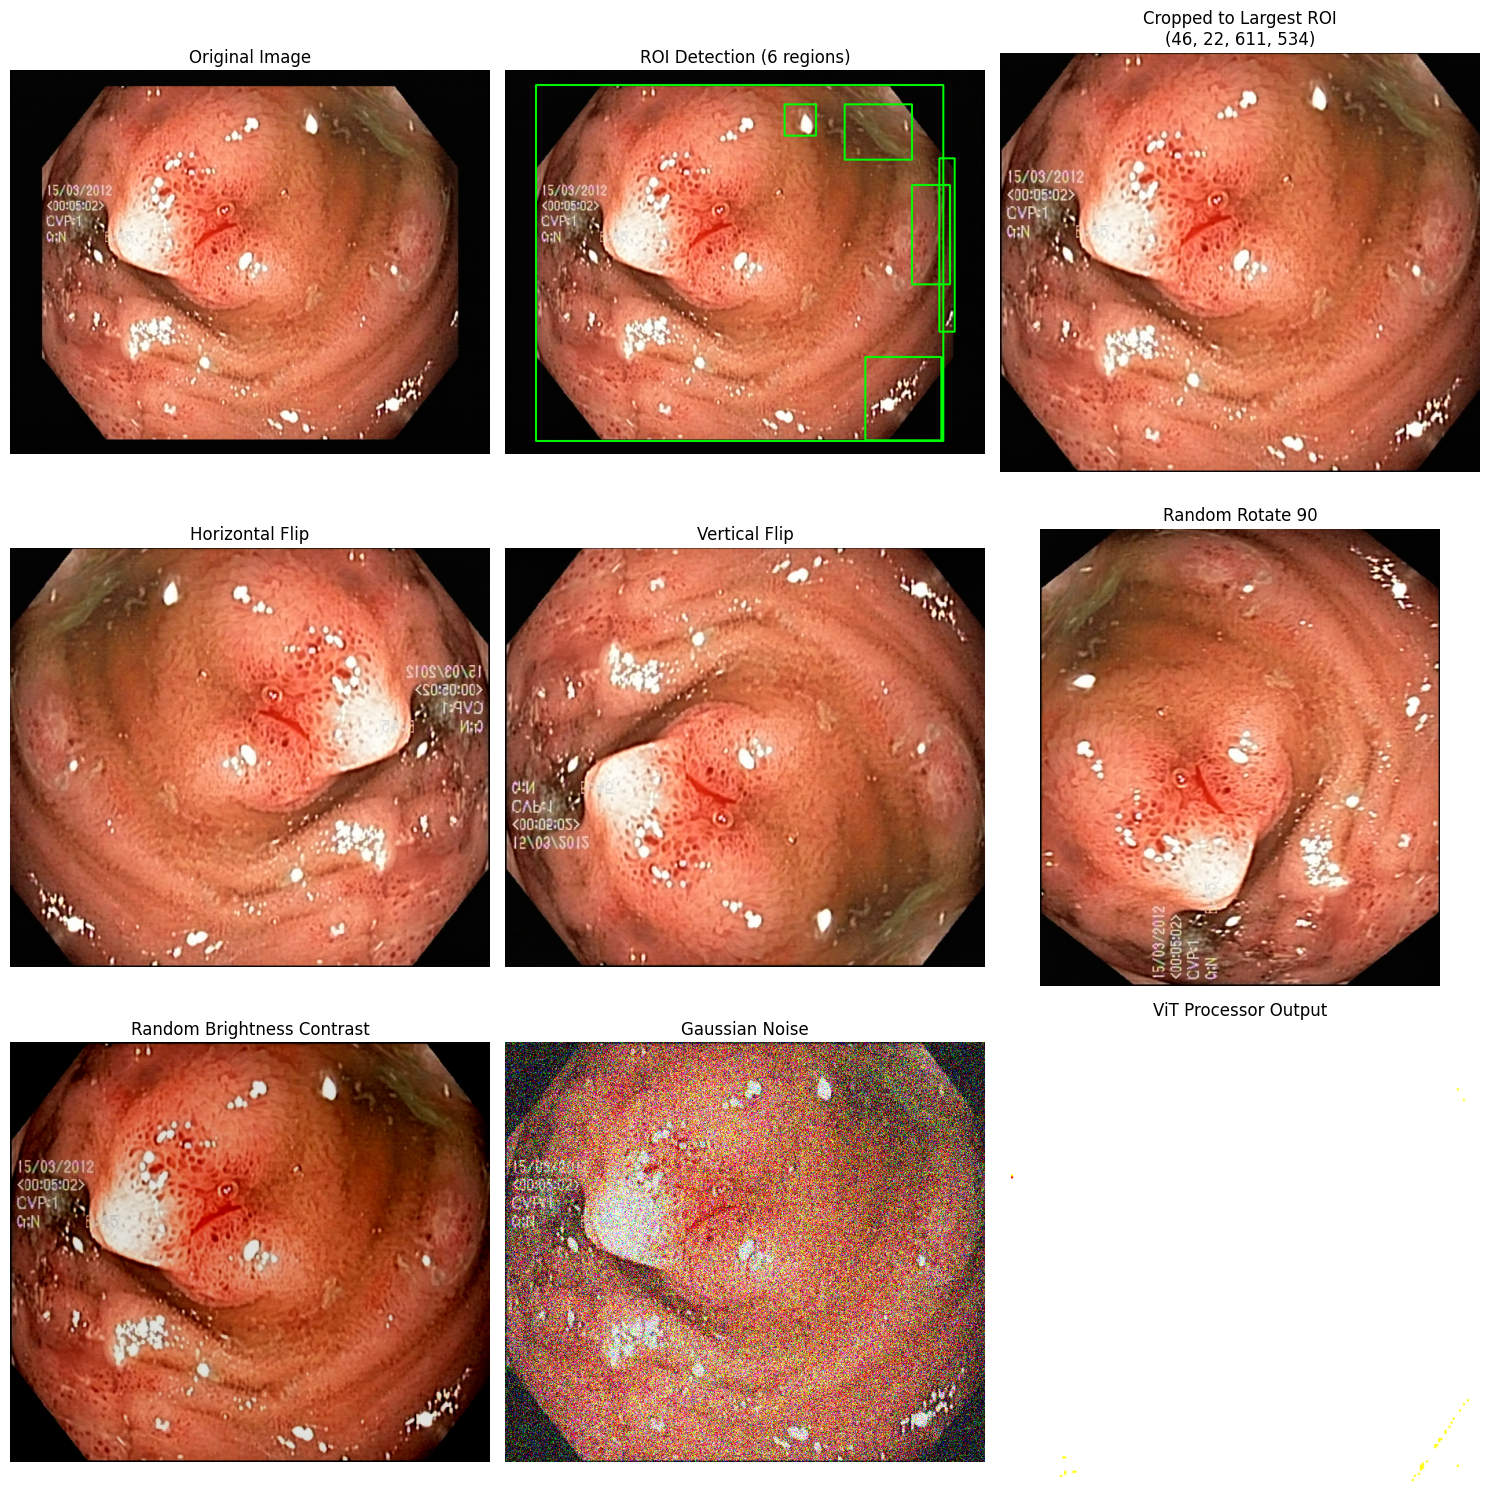

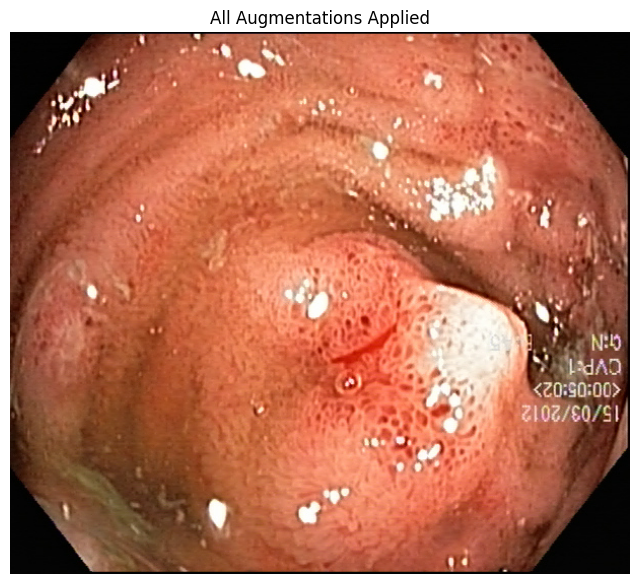

In [6]:
visualize_preprocessing(r"G:\USER\Documents\GitHub\Masters-Project\Datasets\Samples\polyp-sample.jpg")

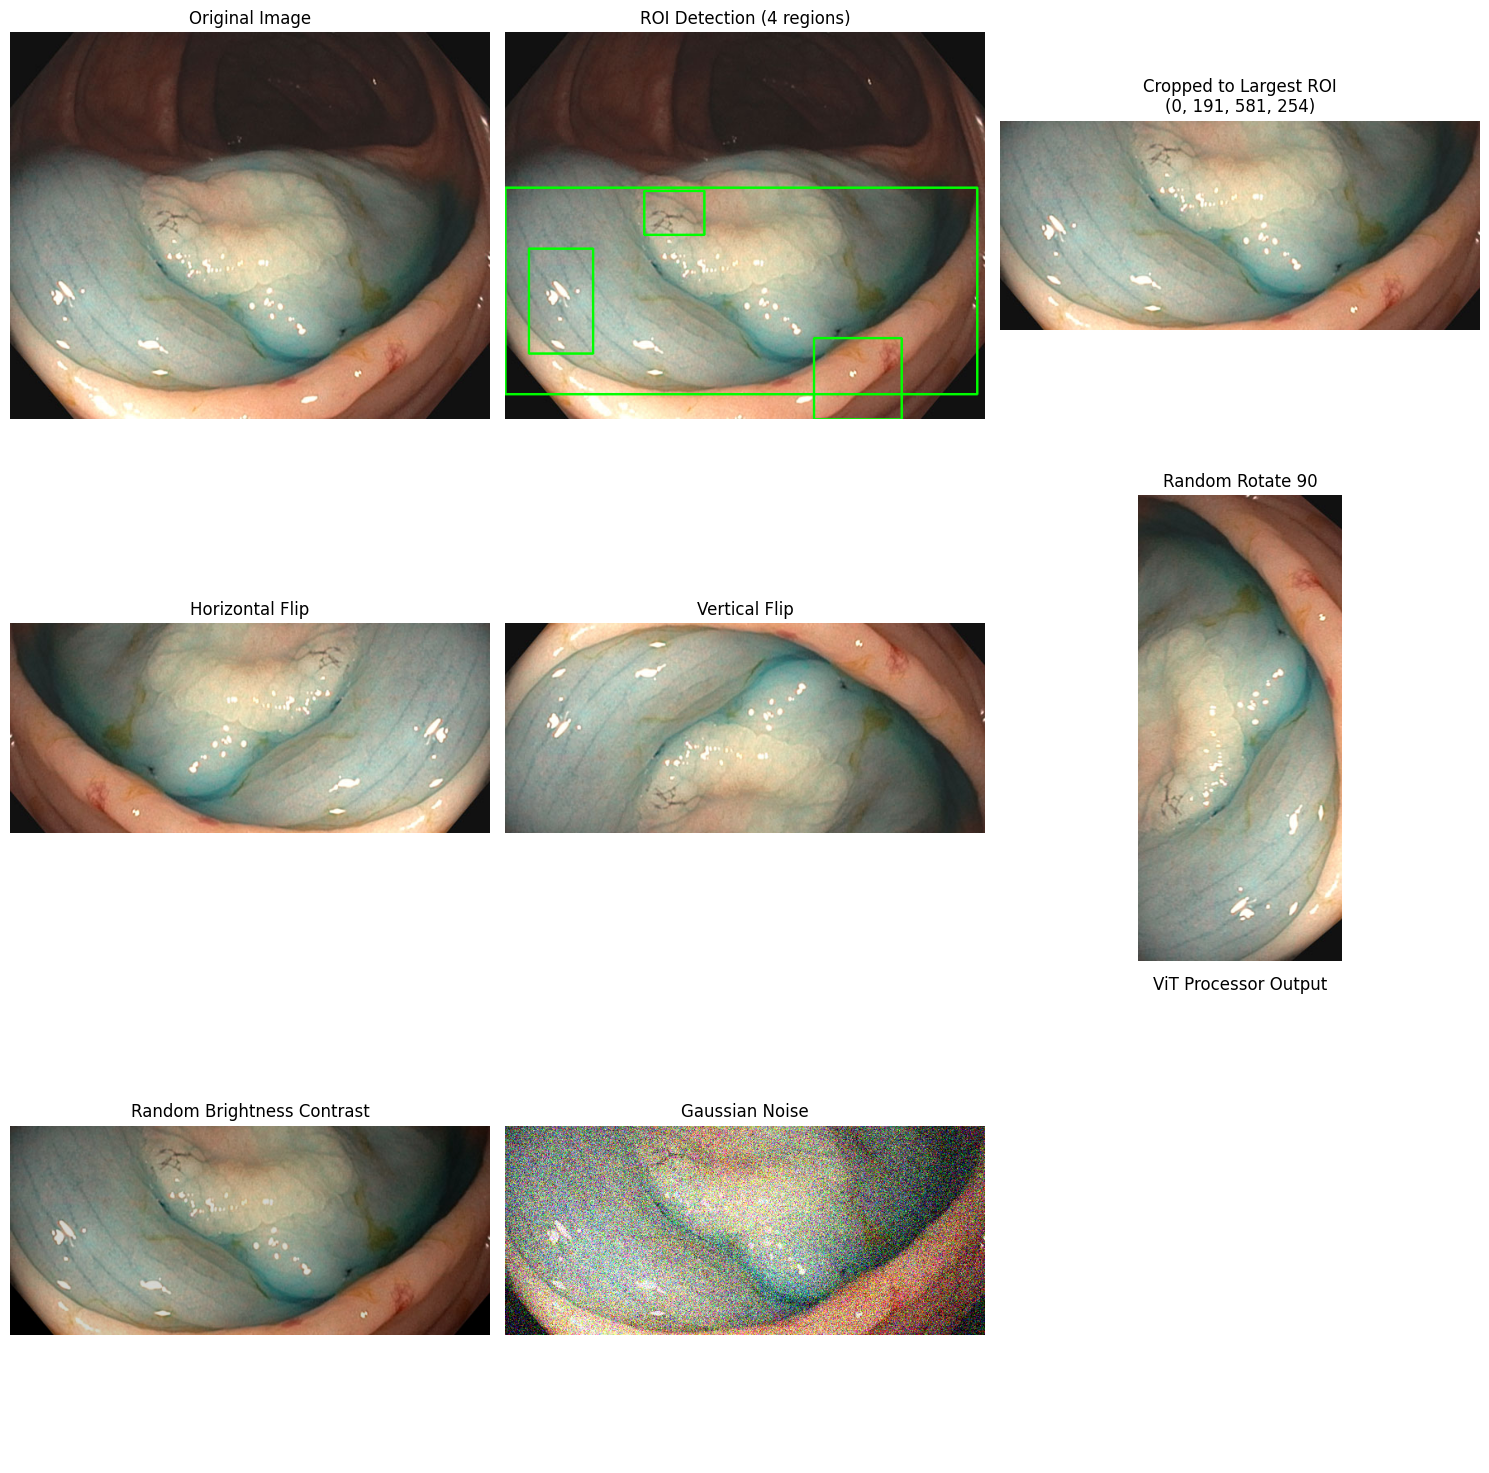

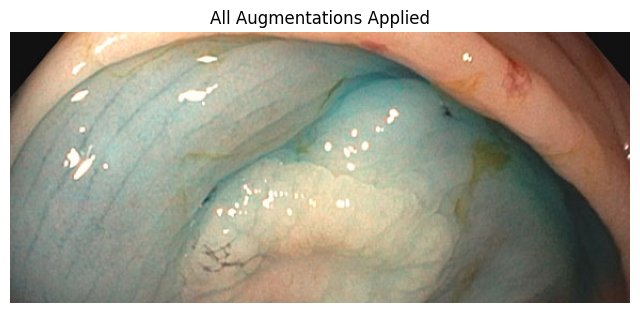

In [7]:
visualize_preprocessing(r"G:\USER\Documents\GitHub\Masters-Project\Datasets\Samples\dyed-lifted-polyp-sample.jpg")

In [8]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [9]:
def train_vit_model(model, train_loader, val_loader, classes, patience=3):
    if os.path.exists(MODEL_PATH):
        logger.info(f"Existing model found at {MODEL_PATH}. Skipping training.")
        model.load_state_dict(torch.load(MODEL_PATH))
        return model

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    early_stopping = EarlyStopping(patience=patience)
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
        for images, labels in train_pbar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{train_loss/len(train_loader):.4f}'})
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Val]')
        with torch.no_grad():
            for images, labels in val_pbar:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_pbar.set_postfix({
                    'loss': f'{val_loss/len(val_loader):.4f}',
                    'acc': f'{100*correct/total:.2f}%'
                })
        
        avg_val_loss = val_loss/len(val_loader)
        early_stopping(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), MODEL_PATH)
        
        if early_stopping.early_stop:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    return model


In [10]:
def test_model(model, test_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    test_pbar = tqdm(test_loader, desc='Testing')
    with torch.no_grad():
        for images, labels in test_pbar:
            images_for_vit = images.to(DEVICE)
            outputs = model(images_for_vit).logits
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Classification Report   
    report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
    print("Classification Report:\n", report)
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'confusion_matrix.png'))
    plt.close()
    
    return all_preds, all_labels

In [11]:
def main():
    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    
    # Prepare dataset
    dataset = prepare_dataset(DATA_DIR)
    
    # Transformations
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    
    # Create datasets
    train_dataset = KvasirDataset(dataset['train_paths'], dataset['train_labels'], transform)
    val_dataset = KvasirDataset(dataset['val_paths'], dataset['val_labels'], transform)
    test_dataset = KvasirDataset(dataset['test_paths'], dataset['test_labels'], transform)
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # Initialize ViT model
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224", 
        num_labels=len(dataset['classes']),
        attn_implementation="sdpa", 
        torch_dtype=torch.float32,
        ignore_mismatched_sizes=True
    ).to(DEVICE)
    
    # Train or load the ViT model
    trained_model = train_vit_model(model, train_loader, val_loader, dataset['classes'])
    
    # Test the model
    test_model(trained_model, test_loader, dataset['classes'])

if __name__ == "__main__":
    main()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 4/10 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:43<00:00,  3.72it/s, loss=0.5477, acc=78.12%]


Early stopping triggered after 4 epochs


Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:10<00:00,  2.83it/s]


Classification Report:
                         precision    recall  f1-score   support

    dyed-lifted-polyps     0.9484    0.7350    0.8282       200
dyed-resection-margins     0.8611    0.9300    0.8942       200
           esophagitis     0.6364    0.3500    0.4516       200
          normal-cecum     0.8288    0.9200    0.8720       200
        normal-pylorus     0.8680    0.8550    0.8615       200
         normal-z-line     0.5874    0.8400    0.6914       200
                polyps     0.8382    0.7250    0.7775       200
    ulcerative-colitis     0.7676    0.9250    0.8390       200

              accuracy                         0.7850      1600
             macro avg     0.7920    0.7850    0.7769      1600
          weighted avg     0.7920    0.7850    0.7769      1600

